In [1]:
from sentence_to_predicate import WordPredicate
import json
import sentence_grounding_test_parameters as param
import numpy as np
from recognized_object import RecognizedObject

from plots import *
from data_processing import *

import sys
import time
import matplotlib.pyplot as plt
import math
import os
from sklearn.model_selection import KFold
import pandas as pd
from sklearn.metrics import mean_squared_error
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
from tensorflow import keras

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Masking, GRU
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from transformers import BertModel, BertTokenizer
from transformers import pipeline
from attention import Attention

In [3]:
def padding(data_set, max_seq_len = None, special_value = -42):
    if data_set is None:
        return  np.full((1, max_seq_len, nb_unique_words), fill_value=special_value)

    if max_seq_len is None:
        max_seq_len = max([len(s) for s in data_set])

    data_set_pad = np.full((len(data_set), max_seq_len, nb_unique_words), fill_value=special_value)

    for s, x in enumerate(data_set):
        if x is None:
            continue
        seq_len = x.shape[0]
        data_set_pad[s, 0:seq_len, :] = x
    return data_set_pad

In [4]:
def test_with_sentences(sentences, model):
    global max_seq_len
    test = [one_hot_encoding_sentence(s) for s in sentences]
    #test = []
    test_pad = padding(test, max_seq_len)
    res = model.predict(test_pad)
    return res

In [5]:
def is_a_valid_imagined_object(predicate, imagined_object):
    """
        Returns whether the predicate description could apply to the imagine_object.

        Inputs:
            predicate: WordPredicate instance
            imagined_object: RecognizedObject instance

    """

    #target = possible_recognized_object_for_predicate(predicate, fill_unkown_fields = False)

    for field in ['category', 'position', 'color']:

        wanted_field = getattr(predicate, field)

        if wanted_field is not None and getattr(imagined_object, field) != wanted_field:
            return False

    return True

def is_a_valid_representation(predicates, imagined_objects):
    """
        Returns whether each predicate  description could apply to its
        corresponding imagined_object.


        Inputs:
            predicates: a list of WordPredicate instances
            imagined_objects: a list of RecognizedObject instance
    """

    return all(map(is_a_valid_imagined_object, predicates, imagined_objects))




def is_an_exact_imagined_object(predicate, imagined_object):
    """
        Returns whether the imagined object matches exactly what the predicate
        describes.

        Inputs:
            predicate: WordPredicate instance
            imagined_object: RecognizedObject instance

    """
    #target = possible_recognized_object_for_predicate(predicate, fill_unkown_fields = False)

    for field in ['category', 'position', 'color']:

        if getattr(imagined_object, field) != getattr(predicate, field):
            return False

    return True

def is_an_exact_representation(predicates, imagined_objects):
    """
        Returns whether the imagined object matches exactly what the predicate
        describes.

        Inputs:
            predicates: a list of WordPredicate instances
            imagined_objects: a list of RecognizedObject instance
    """

    return all(map(is_an_exact_imagined_object, predicates, imagined_objects))

In [6]:
def generate_labels_valid(sentences):
    words = sentences.replace(".", "").split()
    obj = []
    col = []
    pos = []
    for w in words:
        #print(w)
        if '<'+w+'_obj>' in concepts:
            obj.append('<'+w+'_obj>')
        if '<'+w+'_col>' in concepts:
            col.append('<'+w+'_col>')
        if '<'+w+'_pos>' in concepts:
            pos.append('<'+w+'_pos>')
    ss = ''
    if len(obj)>0:
        if len(pos)>0:
            if len(col)>0:
                return RecognizedObject(obj[0],pos[0],col[0])
            else:
                return RecognizedObject(obj[0],pos[0],None)
        else:
            if len(col)>0:
                return RecognizedObject(obj[0],None,col[0])
            else:
                return RecognizedObject(obj[0],None,None)
    else:
        if len(pos)>0:
            if len(col)>0:
                return RecognizedObject(None,pos[0],col[0])
            else:
                return RecognizedObject(None,pos[0],None)
        else:
            if len(col)>0:
                return RecognizedObject(None,None,col[0])
            else:
                return RecognizedObject(None,None,None)

In [7]:
def test_on_test_set(model, testX, testY, test_sentences, verbose, threshold_factor):
    test_outputs = model.predict(testX)
    #print(test_outputs[0].shape)
    test_res = model.test_on_batch(testX, testY)
    exact = 0
    valid = 0
    for i in np.arange(len(test_outputs)):
        v = output_to_vision(test_outputs[i],nb_concepts,
                             threshold_factor, concepts_delimitations, output_id_to_concept_dict)
        #pred = sentence_to_pred(sentences[i], sent_to_role)
        pred = []
        clauses = test_sentences[i].split(" and ")
        if len(clauses) == 1:
            if len(test_sentences[i].split("."))>2:
                #print(s.split("."))
                pred.append(generate_labels_valid(test_sentences[i].split(".")[0]))
                pred.append(generate_labels_valid(test_sentences[i].split(".")[1]))
            else:
                pred.append(generate_labels_valid(test_sentences[i]))
                pred.append(RecognizedObject(None,None,None))
        else:
            for j in range(len(clauses)):
                pred.append(generate_labels_valid(clauses[j]))
        #print(v, pred)       
        if is_an_exact_representation(pred, v):
            exact +=1

        if is_a_valid_representation(pred, v):
            valid +=1

        if is_a_valid_representation(pred, v) and not(is_an_exact_representation(pred, v)):
            #print(pred, v, test_outputs[i])
            #print(i)
            pass

    nb_sample = testX.shape[0]
    test_res = mean_squared_error(test_outputs,testY)
    if verbose:
        print("Valid representations : ", valid, "/", nb_sample)
        print("Exact representations : ", exact, "/", nb_sample)
        print("MSE on test : ", test_res)
        print("RMSE on test : ", np.sqrt(test_res))


    return 1-valid/nb_sample, 1-exact/nb_sample, test_res

In [8]:
## to get the evolution of the loss during training
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        self.exact_errors = []
        self.valid_errors = []

    def on_epoch_end(self, epoch, logs=None):
        global validationX_pad
        global validationY
        self.losses.append(logs.get('loss'))

        v, ex, er = test_on_test_set(self.model, validationX_pad, validationY, validation_sentences, True, 1.3)

        self.val_losses.append(er)
        self.exact_errors.append(ex)
        self.valid_errors.append(v)

    def plot_loss(self):
        plt.figure()
        plt.plot(self.losses, color = "black", label = "loss")
        plt.plot(self.val_losses, color = "red", label = "loss on validation set")
        plt.xlabel("epochs of training")
        plt.title("MSE during training")
        plt.legend()
        plt.show()
        plt.figure()
        plt.title("Performance on validation set during training")
        plt.plot(self.exact_errors, color = "blue", label = "exact error")
        plt.plot(self.valid_errors, color = "green", label = "valid error")
        plt.legend()
        plt.show()

In [9]:
def get_successive_outputs(sentence, model):
    words = sentence.split(" ")
    prefixes = []
    for i in range(len(words)+1):
        prefixes.append(" ".join(words[:i]))
    print(prefixes)
    vect = test_with_sentences(prefixes[1:], model)
    return vect

In [10]:
def get_inner_states(sentences, model, only_last = False, info_obj_nb = False):
    all_states = [[] for i in range(len(model.outputs))]

    clause_nbs =[]

    for k in range(len(sentences)):
        states = get_successive_outputs(sentences[k], model)

        if info_obj_nb:
            words = sentences[k].split(" ")
            clause_id = 0
            clause_nbs.append(clause_id)
            for w in words:
                if w == 'and':
                    clause_id +=1
                clause_nbs.append(clause_id)
                if w == 'and':
                    clause_id +=1
            clause_nbs[-1] = 3 #we also mark the final states

        if not(only_last):
            for j in range(len(states)):
                all_states[j].append(states[j])
        else:
            for j in range(len(states)):
                all_states[j].append(states[j][-1] )

    if not(only_last):
        for i in range(len(all_states)):
            all_states[i] = np.concatenate(all_states[i])
    else:
        for i in range(len(all_states)):
            all_states[i] = np.array(all_states[i])

    if info_obj_nb:
        return all_states, np.array(clause_nbs)
    else:
        return all_states

In [11]:
def plot_hidden_states(sentence, model_for_test, state = 'cell', units_to_plot = 'all', plt_var = False, plt_sum = False):
    activations = get_successive_outputs(sentence, model_for_test)

    plot_hidden_state_activation(sentence,
                                 activations,
                                 state,
                                 units_to_plot,
                                 plot_variation = plt_var,
                                 plot_sum = plt_sum)

In [12]:
dataset = pd.read_csv('./text.tsv', sep='\t')
dataset.dropna()
dataset.head()

,hit_id,worker_id,worktime_s,item_id,text
0,306996CF6WIITTJBR6Q44WPDCQ11BX,1717708c7af5468188e808a8d09b5c98,380,potato_3_2,A single small red skinned potato is laying on...
1,306996CF6WIITTJBR6Q44WPDCQ11BX,1717708c7af5468188e808a8d09b5c98,380,can_opener_4_3,The manual can opener has a black plastic hand...
2,306996CF6WIITTJBR6Q44WPDCQ11BX,1717708c7af5468188e808a8d09b5c98,380,measuring_tape_3_3,A pink and black measuring tape is laying on i...
3,306996CF6WIITTJBR6Q44WPDCQ11BX,1717708c7af5468188e808a8d09b5c98,380,fork_3_1,A silver metal fork is laying with its tines p...
4,306996CF6WIITTJBR6Q44WPDCQ11BX,1717708c7af5468188e808a8d09b5c98,380,can_opener_3_4,A manual can opener with a light blue plastic ...


In [13]:
concepts = []
sentences = []
for i in np.arange(dataset.shape[0]):
    try:
        #print(i.split('_'))
        if len(dataset['item_id'][i].split('_')) == 3:
            concepts.append(dataset['item_id'][i].split('_')[0])
            sentences.append(dataset['text'][i])
        else:
            concepts.append(dataset['item_id'][i].split('_')[0]+" "+dataset['item_id'][i].split('_')[1])
            sentences.append(dataset['text'][i])
        #else:
        #    concepts.append(dataset['item_id'][i].split('_')[0]+dataset['item_id'][i].split('_')[1])
        #    sentences.append(dataset['text'][i].replace(dataset['item_id'][i].split('_')[0]+" "+dataset['item_id'][i].split('_')[1],dataset['item_id'][i].split('_')[0]+dataset['item_id'][i].split('_')[1]))
    except:
        continue

In [14]:
final_sentences = []
final_concepts = []
for s in sentences:
    try:
        if s.split(" "):
            final_sentences.append(s.lower())
    except:
        print(s)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [15]:
object_names = np.random.choice(np.unique(concepts),10)

In [16]:
#object_names = np.unique(concepts)
color_names = ['red', 'black', 'blue', 'green', 'white', 'pink', 'orange', 'yellow']
position_names = ['left', 'right', 'middle', 'top', 'bottom', 'front', 'back']

In [17]:
final = []
for i in final_sentences:
    for j in object_names:
        if j in i:
            final.append(i)

In [18]:
def add_object(name, concept = None, build_after = True):
    
    if concept is None:
        concept = '<' + name.lower() + '_obj>'
    
    if name not in OBJECT_NAMES:
        OBJECT_NAMES.append(name)
        
    if concept not in CATEGORIES:
        CATEGORIES.append(concept)
        
    OBJ_NAME_TO_CONCEPT[name] = concept
    
    if build_after:
        build_all()
    
    
def add_position(name, concept = None, build_after=True):
    
    if concept is None:
        concept = '<' + name.lower() + '_pos>'
    
    if name not in POSITION_NAMES:
        POSITION_NAMES.append(name)
    
    if concept not in POSITIONS:
        POSITIONS.append(concept)
        
    POSITION_NAME_TO_CONCEPT[name] = concept
    
    if build_after:
        build_all()
       
        
def add_color(name, concept = None, build_after=True):
    
    if concept is None:
        concept = '<' + name.lower() + '_col>'
    
    
    if name not in COLOR_NAMES:
        COLOR_NAMES.append(name)
    
    if concept not in COLORS:
        COLORS.append(concept)
        
    COLOR_NAME_TO_CONCEPT[name] = concept
    
    if build_after:
        build_all()

In [19]:
# Words
OBJECT_NAMES = []
COLOR_NAMES = []
POSITION_NAMES = []

# Concepts
CATEGORIES = []
POSITIONS = []
COLORS = []

OBJ_NAME_TO_CONCEPT = dict()
COLOR_NAME_TO_CONCEPT = dict()
POSITION_NAME_TO_CONCEPT = dict()

In [20]:
for obj in object_names:
    add_object(obj, build_after = False)
        
for col in color_names:
    add_color(col, build_after = False)
        
for pos in position_names:
    add_position(pos, build_after = False)

In [22]:
################### MAIN #####################

## Parameters

add_begin_end = True #add the word "BEGIN" at the beggining and "END" at the end of all sentences ?
#nb_objects = np.unique(concepts).shape[0] #number of object in the vocabulary used to generate the sentences (the bigger the harder)
nb_objects = 10

special_value = -42 #special value for masking
batch_size = 2
nb_epoch = 70
lstm_units = 20
dropout = 0.2
test_version = True #if we just create a model to do the task (named "model" in the code)
                    #or in addition, create a model to do extensive test to get access to
                    #cell states of the LSTM (named "model_for_test" in the code)

use_save_version = False #use model saved from a previous run
if use_save_version:
    path = r"saved_LSTM/" #path to the model .hdf5 file(s)
    model_id = '0.9144544314163248' #model id (a random float to identify the file(s) of the model save)

threshold_factor = 1.3 # the factor used to get the threshold in the creation of he discrete representation


minimal_mode = False #if minimal mode is on, the model will only be trained and tested on test set. The only text print will be "nb of objects, valid error on test set, exact error on test set, RMSE on test set, time to train"

verbose_training = True

In [23]:
other_words = []
if add_begin_end:
    other_words.append("BEGIN")
    other_words.append("END")

#init_one_hot_encoding(list(sent_to_role.keys()) + other_words)
#nb_unique_words = len(word2one_hot_id)

In [24]:
#concept dictionnary initialisation (it's the link between the output position and their meaning)
concepts = CATEGORIES + POSITIONS + COLORS

nb_concepts = len(concepts)

output_size = 2*nb_concepts

concept_to_output_id_dict = {}
output_id_to_concept_dict = {}
for i,c in enumerate(concepts):
    concept_to_output_id_dict[c] = i
    output_id_to_concept_dict[i] = c

In [25]:
concepts_delimitations = [(0,len(CATEGORIES)),
                          (len(CATEGORIES),
                          len(CATEGORIES) + len(POSITIONS)),
                          (len(CATEGORIES) + len(POSITIONS),
                          len(CATEGORIES) + len(POSITIONS)+ len(COLORS))]

In [26]:
len(final)

1138

In [27]:
##generate data
#we adjust the different dictionnaries to include sentences with BEGIN and END
final_sentences = final
if add_begin_end:
    for i in range(len(final_sentences)):
        final_sentences[i] = "BEGIN "+ final_sentences[i]+ " END"

In [28]:
#create the training, test and validation set

np.random.shuffle(final_sentences)

train_data = 900

test_data = 238


In [29]:
init_one_hot_encoding(final_sentences + other_words)
nb_unique_words = len(word2one_hot_id)

In [30]:
train_sentences = (final_sentences[:train_data])


test_sentences = (final_sentences[-test_data:])

In [31]:
def generate_labels(sen_num, index_num, s):
    words = s.replace(".", "").split()
    for w in words:
        if '<'+w+'_obj>' in concepts:
            trainY[sen_num][index_num+concepts.index('<'+w+'_obj>')]=1
        if '<'+w+'_col>' in concepts:
            trainY[sen_num][index_num+concepts.index('<'+w+'_col>')]=1
        if '<'+w+'_pos>' in concepts:
            trainY[sen_num][index_num+concepts.index('<'+w+'_pos>')]=1

In [32]:
trainY = np.zeros([len(train_sentences),output_size])
print(trainY.shape)
i = 0
more_objects = []
for s in train_sentences:
    try:
        clauses = s.split(" and ")
        if len(clauses) == 1:
            if len(s.split("."))>2:
                #print(s.split("."))
                generate_labels(i, 0, s.split(".")[0])
                generate_labels(i, len(concepts), s.split(".")[1])
            else:
                generate_labels(i, 0, s)
        else:
            for j in range(len(clauses)):
                generate_labels(i, j*len(concepts), clauses[j])
    except:
        more_objects.append(i)
    i+=1

(900, 48)


In [33]:
trainY = np.array(trainY)
trainY = np.delete(trainY,more_objects, axis=0)
print(trainY.shape)

train_sentences = np.array(train_sentences)
train_sentences = np.delete(train_sentences,more_objects, axis=0)
print(train_sentences.shape)

(891, 48)
(891,)


In [34]:
def generate_labels_test(sen_num, index_num, s):
    words = s.replace(".", "").split()
    for w in words:
        if '<'+w+'_obj>' in concepts:
            testY[sen_num][index_num+concepts.index('<'+w+'_obj>')]=1
        if '<'+w+'_col>' in concepts:
            testY[sen_num][index_num+concepts.index('<'+w+'_col>')]=1
        if '<'+w+'_pos>' in concepts:
            testY[sen_num][index_num+concepts.index('<'+w+'_pos>')]=1

In [35]:
testY = np.zeros([len(test_sentences),output_size])
#print(target_output.shape)
i = 0
more_objects_test = []
for s in test_sentences:
    try:
        clauses = s.split(" and ")
        if len(clauses) == 1:
            if len(s.split("."))>2:
                #print(s.split("."))
                generate_labels_test(i, 0, s.split(".")[0])
                generate_labels_test(i, len(concepts), s.split(".")[1])
            else:
                generate_labels_test(i, 0, s)
        else:
            for j in range(len(clauses)):
                generate_labels_test(i, j*len(concepts), clauses[j])
    except:
        more_objects_test.append(i)
    i+=1

In [36]:
testY = np.array(testY)
testY = np.delete(testY,more_objects_test, axis=0)
print(testY.shape)

test_sentences = np.array(test_sentences)
test_sentences = np.delete(test_sentences,more_objects_test, axis=0)
print(test_sentences.shape)

(238, 48)
(238,)


In [37]:
trainX = [one_hot_encoding_sentence(s) for s in train_sentences]
#trainY = np.array([sentence_to_output_teacher_vector(s,
#                                                     concept_to_output_id_dict,
#                                                     nb_concepts) for s in train_sentences])


testX = [one_hot_encoding_sentence(s) for s in test_sentences]
#testY = np.array([sentence_to_output_teacher_vector(s,
#                                                    sent_to_role,
#                                                    concept_to_output_id_dict,
#                                                    nb_concepts) for s in test_sentences])


In [38]:
#create the training, test and validation set
validationX = testX[50:]
validationY = testY[50:]
validation_sentences = test_sentences[50:] 

In [39]:
#nb_unique_words=768
max_seq_len = max([len(s.split(" ")) for s in final_sentences])

trainX_pad = padding(trainX,max_seq_len = max_seq_len)
testX_pad = padding(testX, max_seq_len = max_seq_len)
validationX_pad = padding(validationX, max_seq_len = max_seq_len)

In [40]:
print(trainX_pad.shape, testX_pad.shape, validationX_pad.shape)

(891, 45, 846) (238, 45, 846) (188, 45, 846)


In [41]:
CONCEPT_LISTS = [
            CATEGORIES,
            POSITIONS,
            COLORS
            ]
def plot_concept_activation(sentence, activations, concepts_delim,nb_concepts, output_function = None, savefig=False, sub_ttl_fig='', ylims=(-0.4, 1.4)):
    """
        Plots activation through time of the different concepts while hearing
        the sentence. If output_function is not None, it is applied to the reservoir
        output vector before plotting.
        This is a reuse of a function developped by Alexis Juven.
    """

    outputs = activations.copy()
    activation_threshold = 0.5

    if output_function is not None:

        activation_threshold = output_function(activation_threshold)

        for i in range(outputs.shape[0]):
            outputs[i, :] = output_function(outputs[i, :])


    words = sentence.split(" ")
    max_nb_seen_objects = 2
    nb_object_properties = 3

    fig, axes = plt.subplots(nb_object_properties, max_nb_seen_objects, figsize=(25,20))


    concept_delimitations = [t[0] for t in concepts_delim] + [concepts_delim[-1][1]]

    for i in range(max_nb_seen_objects):

        offset = i * nb_concepts

        axes[0, i].set_title("Object " + str(i+1), fontsize = 22)

        for j in range(nb_object_properties):

            ax = axes[j, i]
            ax.plot(outputs[:, offset + concept_delimitations[j] : offset + concept_delimitations[j+1]], linewidth = 4)
            ax.legend(CONCEPT_LISTS[j], loc = 2, fontsize = 22)

            ax.set_yticks([0., 0.5, 1.])
            ax.set_yticklabels([0., 0.5, 1.], fontsize = 20)

            ax.set_ylim([ylims[0], ylims[1]])

            ax.set_xticks(np.arange(len(words)))
            ax.set_xticklabels(words, fontsize = 24)
            # Rotate the tick labels and set their alignment.
            plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize = 22)

            ax.plot(len(words) * [activation_threshold], '--', color = 'grey', linewidth = 3)

    fig.suptitle(sentence, fontsize = 26)
    plt.subplots_adjust(hspace = 0.3)

    if savefig:
        plt.savefig('sentence_'+sub_ttl_fig+".png", bbox_inches='tight')
        plt.close()
    else:
        fig.show()
        #plt.show()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 45, 846)]    0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (None, 45, 846)      0           input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 45, 20), (No 69360       masking_1[0][0]                  
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 20)           0           lstm_1[0][0]                     
____________________________________________________________________________________________

Epoch 8/70
Valid representations :  141 / 188
Exact representations :  136 / 188
MSE on test :  0.009955015643224296
RMSE on test :  0.09977482469653502

Epoch 00008: val_loss improved from 0.01050 to 0.00996, saving model to saved_LSTM/best_model0.354240367322048.hdf5
446/446 - 5s - loss: 0.0109 - val_loss: 0.0100
Epoch 9/70
Valid representations :  147 / 188
Exact representations :  145 / 188
MSE on test :  0.009471695357984556
RMSE on test :  0.09732263538347365

Epoch 00009: val_loss improved from 0.00996 to 0.00947, saving model to saved_LSTM/best_model0.354240367322048.hdf5
446/446 - 5s - loss: 0.0102 - val_loss: 0.0095
Epoch 10/70
Valid representations :  153 / 188
Exact representations :  150 / 188
MSE on test :  0.009073554303155054
RMSE on test :  0.09525520617349507

Epoch 00010: val_loss improved from 0.00947 to 0.00907, saving model to saved_LSTM/best_model0.354240367322048.hdf5
446/446 - 5s - loss: 0.0101 - val_loss: 0.0091
Epoch 11/70
Valid representations :  152 / 188
E

Epoch 36/70
Valid representations :  167 / 188
Exact representations :  155 / 188
MSE on test :  0.007041511889647463
RMSE on test :  0.08391371693380924

Epoch 00036: val_loss did not improve from 0.00685
446/446 - 5s - loss: 0.0058 - val_loss: 0.0070
Epoch 37/70
Valid representations :  164 / 188
Exact representations :  152 / 188
MSE on test :  0.006936421595595154
RMSE on test :  0.08328518232912235

Epoch 00037: val_loss did not improve from 0.00685
446/446 - 5s - loss: 0.0059 - val_loss: 0.0069
Epoch 38/70
Valid representations :  165 / 188
Exact representations :  152 / 188
MSE on test :  0.007039631827109891
RMSE on test :  0.08390251383069455

Epoch 00038: val_loss did not improve from 0.00685
446/446 - 5s - loss: 0.0059 - val_loss: 0.0070
Epoch 39/70
Valid representations :  163 / 188
Exact representations :  151 / 188
MSE on test :  0.007003713990999686
RMSE on test :  0.08368819505163011

Epoch 00039: val_loss did not improve from 0.00685
446/446 - 5s - loss: 0.0059 - val_l

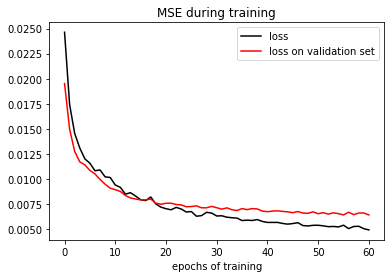

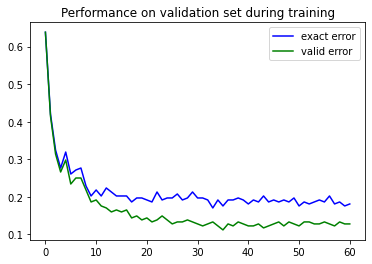

Testing on test set ...


UnboundLocalError: local variable 'batch_outputs' referenced before assignment

In [43]:
for _ in np.arange(1):
    if __name__ == "__main__":
        for i in np.arange(1):
            if use_save_version:
                model = keras.models.load_model(path + "best_model"+rand_id+".hdf5")
                if test_version:
                    model_for_test = keras.models.load_model(path + "best_model_for_test"+rand_id+".hdf5")

            else:
                rand_id = str(np.random.random()) #random id used for the file names during the model save

                #build the model
                if test_version:
                    inp = Input((max_seq_len, nb_unique_words))
                    masked = Masking(mask_value=special_value)(inp)
                    lstm_out, state_h, state_c = LSTM(lstm_units, return_sequences=True, return_state = True, dropout = dropout)(masked)
                    attention_weights, attention_output = Attention(20)(lstm_out)
                    output_to_train = Dense(output_size)(attention_output)
                    
                    model = Model(inputs = inp, outputs = output_to_train)
                    model_for_test = Model(inputs = inp, outputs = [output_to_train, state_h, state_c])
                    model.compile(loss='mean_squared_error', optimizer='adam')
                    model_for_test.compile(loss='mean_squared_error', optimizer='adam')

                    if verbose_training:
                        print("model for hidden states: ", model_for_test.summary())
                else:
                    model = Sequential()
                    model.add(Masking(mask_value=special_value, input_shape=(max_seq_len, nb_unique_words)))
                    model.add(LSTM(lstm_units, stateful=False))
                    model.add(Dense(output_size))
                    model.compile(loss='mean_squared_error', optimizer='adam')

                if verbose_training:
                    print(model.summary()) # print the architecture of the model

                if not(minimal_mode):
                    history = LossHistory() #to get the evolution of the loss during training
                    checkpoint = ModelCheckpoint("saved_LSTM/best_model"+rand_id+".hdf5",
                                                monitor='val_loss', verbose=1,
                                                mode='auto', period=1, save_best_only = True) #we save the model after each epoch of training
                    earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

                t1 = time.process_time()

                #training
                if minimal_mode:
                    model.fit(trainX_pad, trainY, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
                else:
                    model.fit(trainX_pad, trainY, epochs=nb_epoch, batch_size=batch_size, verbose=2, shuffle=False, callbacks=[history, checkpoint, earlystopping], validation_data=(validationX_pad, validationY))


                t2 = time.process_time()

                if verbose_training:
                    print("End of training !")
                    print("CPU Time to train : ", t2 -t1)
                if not(minimal_mode):
                    model_for_test.save("saved_LSTM/best_model_for_test"+rand_id+".hdf5")
                    history.plot_loss()


            if verbose_training:
                print("Testing on test set ...")
            v, ex, er = test_on_test_set(model, testX_pad[300:] , testY[300:], test_sentences[300:], verbose_training, threshold_factor)
            if minimal_mode:
                print(str(nb_objects) + "," +str(v) + "," + str(ex) + ","+ str(er) + "," + str(t2-t1))

            if not(minimal_mode):
                if verbose_training:
                    print("Testing on training set ...")
                v, ex, er = test_on_test_set(model, trainX_pad , trainY, train_sentences, True, threshold_factor)


            #qualitative analysis of the output of the LSTM
            if not(minimal_mode):
                test_sent = ["BEGIN on the middle is a green glass and that is a orange bowl END", #0
                "BEGIN and on the middle is a green glass and that is a orange bowl END",
                "BEGIN a blue bowl is on the right and on the right there is the blue bowl END",
                "BEGIN on the middle there is the orange and the orange on the middle is orange END", #3
                "BEGIN the orange is orange and on the middle there is the green cup END",
                "BEGIN on the left there is a blue glass and this is a orange END",
                "BEGIN the glass on the left is blue and the bowl on the right is green END", #6
                "BEGIN the orange on the right is green and there is a blue cup on the middle END",
                "BEGIN on the right there is a red glass and the cup on the middle is red END",
                "BEGIN a green glass is on the right and on the left is a orange END"] #9

                #plot the final outputs on a test sentence
                outputs = test_with_sentences(test_sent , model)
                ind = i
                plot_final_activation(outputs[ind],
                                    concepts_delimitations,
                                    output_id_to_concept_dict,
                                    nb_concepts,
                                    test_sent[ind])

                #plot and save to png the evolution of the LSTM outputs during the processing of a sentence
                s = test_sent[ind]
                suc_outputs = get_successive_outputs(s, model)
                plot_concept_activation(s,
                                        suc_outputs,
                                        concepts_delimitations,
                                        nb_concepts,
                                        savefig = True,
                                        sub_ttl_fig = s + " LSTM")


                #plot the evolution of cell activity
                activations = get_successive_outputs(s, model_for_test)
                plot_hidden_states(s,
                                model_for_test,
                                units_to_plot = 'all',
                                state = 'cell',
                                plt_var = True,
                                plt_sum = False)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 45, 846)]    0                                            
__________________________________________________________________________________________________
masking_3 (Masking)             (None, 45, 846)      0           input_4[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 45, 40), (No 141920      masking_3[0][0]                  
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 40)           0           lstm_3[0][0]                     
____________________________________________________________________________________________

Epoch 8/70
Valid representations :  160 / 188
Exact representations :  151 / 188
MSE on test :  0.008456490952337602
RMSE on test :  0.09195918090292889

Epoch 00008: val_loss did not improve from 0.00840
446/446 - 11s - loss: 0.0085 - val_loss: 0.0085
Epoch 9/70
Valid representations :  161 / 188
Exact representations :  153 / 188
MSE on test :  0.008092554826748422
RMSE on test :  0.08995862841744766

Epoch 00009: val_loss improved from 0.00840 to 0.00809, saving model to saved_LSTM/best_model0.7081627833725521.hdf5
446/446 - 11s - loss: 0.0079 - val_loss: 0.0081
Epoch 10/70
Valid representations :  162 / 188
Exact representations :  152 / 188
MSE on test :  0.008033600460236975
RMSE on test :  0.08963035456940341

Epoch 00010: val_loss improved from 0.00809 to 0.00803, saving model to saved_LSTM/best_model0.7081627833725521.hdf5
446/446 - 11s - loss: 0.0072 - val_loss: 0.0080
Epoch 11/70
Valid representations :  161 / 188
Exact representations :  155 / 188
MSE on test :  0.007799748

Epoch 37/70
Valid representations :  166 / 188
Exact representations :  149 / 188
MSE on test :  0.0063045399823199655
RMSE on test :  0.07940113338183508

Epoch 00037: val_loss did not improve from 0.00622
446/446 - 11s - loss: 0.0040 - val_loss: 0.0063
Epoch 38/70
Valid representations :  165 / 188
Exact representations :  155 / 188
MSE on test :  0.0062602972761442765
RMSE on test :  0.07912204039421808

Epoch 00038: val_loss did not improve from 0.00622
446/446 - 11s - loss: 0.0044 - val_loss: 0.0063
Epoch 39/70
Valid representations :  167 / 188
Exact representations :  154 / 188
MSE on test :  0.006313084081393659
RMSE on test :  0.07945491854752391

Epoch 00039: val_loss did not improve from 0.00622
446/446 - 11s - loss: 0.0045 - val_loss: 0.0063
Epoch 40/70
Valid representations :  169 / 188
Exact representations :  157 / 188
MSE on test :  0.006218974822934712
RMSE on test :  0.0788604769382909

Epoch 00040: val_loss improved from 0.00622 to 0.00622, saving model to saved_LSTM

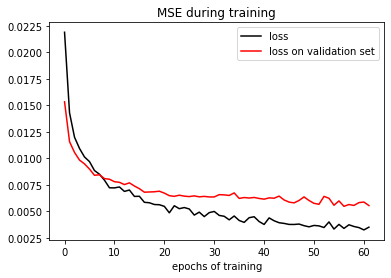

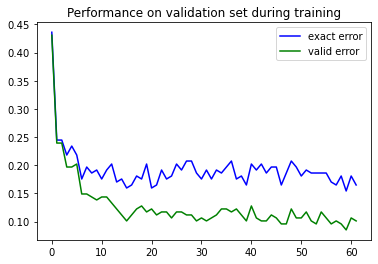

Testing on test set ...
Valid representations :  218 / 238
Exact representations :  204 / 238
MSE on test :  0.005221340403478311
RMSE on test :  0.07225884308151018
Testing on training set ...
Valid representations :  856 / 891
Exact representations :  853 / 891
MSE on test :  0.001173514622219046
RMSE on test :  0.03425659968851325


KeyError: 'cup'

In [46]:
lstm_units = 40
for _ in np.arange(1):
    if __name__ == "__main__":
        for i in np.arange(1):
            if use_save_version:
                model = keras.models.load_model(path + "best_model"+rand_id+".hdf5")
                if test_version:
                    model_for_test = keras.models.load_model(path + "best_model_for_test"+rand_id+".hdf5")

            else:
                rand_id = str(np.random.random()) #random id used for the file names during the model save

                #build the model
                if test_version:
                    inp = Input((max_seq_len, nb_unique_words))
                    masked = Masking(mask_value=special_value)(inp)
                    lstm_out, state_h, state_c = LSTM(lstm_units, return_sequences=True,return_state = True, dropout = dropout)(masked)

                    attention_weights, attention_output = Attention(40)(lstm_out)
                    output_to_train = Dense(output_size)(attention_output)

                    model = Model(inputs = inp, outputs = output_to_train)
                    model_for_test = Model(inputs = inp, outputs = [output_to_train, state_h, state_c])
                    model.compile(loss='mean_squared_error', optimizer='adam')
                    model_for_test.compile(loss='mean_squared_error', optimizer='adam')

                    if verbose_training:
                        print("model for hidden states: ", model_for_test.summary())
                else:
                    model = Sequential()
                    model.add(Masking(mask_value=special_value, input_shape=(max_seq_len, nb_unique_words)))
                    model.add(LSTM(lstm_units, stateful=False))
                    model.add(Dense(output_size))
                    model.compile(loss='mean_squared_error', optimizer='adam')

                if verbose_training:
                    print(model.summary()) # print the architecture of the model

                if not(minimal_mode):
                    history = LossHistory() #to get the evolution of the loss during training
                    checkpoint = ModelCheckpoint("saved_LSTM/best_model"+rand_id+".hdf5",
                                                monitor='val_loss', verbose=1,
                                                mode='auto', period=1, save_best_only = True) #we save the model after each epoch of training
                    earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

                t1 = time.process_time()

                #training
                if minimal_mode:
                    model.fit(trainX_pad, trainY, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
                else:
                    model.fit(trainX_pad, trainY, epochs=nb_epoch, batch_size=batch_size, verbose=2, shuffle=False, callbacks=[history, checkpoint, earlystopping], validation_data=(validationX_pad, validationY))


                t2 = time.process_time()

                if verbose_training:
                    print("End of training !")
                    print("CPU Time to train : ", t2 -t1)
                if not(minimal_mode):
                    model_for_test.save("saved_LSTM/best_model_for_test"+rand_id+".hdf5")
                    history.plot_loss()


            if verbose_training:
                print("Testing on test set ...")
            v, ex, er = test_on_test_set(model, testX_pad[0:] , testY[0:], test_sentences[0:], verbose_training, threshold_factor)
            if minimal_mode:
                print(str(nb_objects) + "," +str(v) + "," + str(ex) + ","+ str(er) + "," + str(t2-t1))

            if not(minimal_mode):
                if verbose_training:
                    print("Testing on training set ...")
                v, ex, er = test_on_test_set(model, trainX_pad , trainY, train_sentences, True, threshold_factor)


            #qualitative analysis of the output of the LSTM
            if not(minimal_mode):
                test_sent = ["BEGIN on the middle is a green glass and that is a orange bowl END", #0
                "BEGIN and on the middle is a green glass and that is a orange bowl END",
                "BEGIN a blue bowl is on the right and on the right there is the blue bowl END",
                "BEGIN on the middle there is the orange and the orange on the middle is orange END", #3
                "BEGIN the orange is orange and on the middle there is the green cup END",
                "BEGIN on the left there is a blue glass and this is a orange END",
                "BEGIN the glass on the left is blue and the bowl on the right is green END", #6
                "BEGIN the orange on the right is green and there is a blue cup on the middle END",
                "BEGIN on the right there is a red glass and the cup on the middle is red END",
                "BEGIN a green glass is on the right and on the left is a orange END"] #9

                #plot the final outputs on a test sentence
                outputs = test_with_sentences(test_sent , model)
                ind = i
                plot_final_activation(outputs[ind],
                                    concepts_delimitations,
                                    output_id_to_concept_dict,
                                    nb_concepts,
                                    test_sent[ind])

                #plot and save to png the evolution of the LSTM outputs during the processing of a sentence
                s = test_sent[ind]
                suc_outputs = get_successive_outputs(s, model)
                plot_concept_activation(s,
                                        suc_outputs,
                                        concepts_delimitations,
                                        nb_concepts,
                                        savefig = True,
                                        sub_ttl_fig = s + " LSTM")


                #plot the evolution of cell activity
                activations = get_successive_outputs(s, model_for_test)
                plot_hidden_states(s,
                                model_for_test,
                                units_to_plot = 'all',
                                state = 'cell',
                                plt_var = True,
                                plt_sum = False)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 45, 846)]    0                                            
__________________________________________________________________________________________________
masking_4 (Masking)             (None, 45, 846)      0           input_5[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 45, 80), (No 296640      masking_4[0][0]                  
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 80)           0           lstm_4[0][0]                     
____________________________________________________________________________________________

Epoch 8/70
Valid representations :  164 / 188
Exact representations :  154 / 188
MSE on test :  0.0077556257988634384
RMSE on test :  0.08806603090217839

Epoch 00008: val_loss improved from 0.00807 to 0.00776, saving model to saved_LSTM/best_model0.9179450429601141.hdf5
446/446 - 12s - loss: 0.0073 - val_loss: 0.0078
Epoch 9/70
Valid representations :  162 / 188
Exact representations :  152 / 188
MSE on test :  0.007859764895685305
RMSE on test :  0.08865531510115626

Epoch 00009: val_loss did not improve from 0.00776
446/446 - 11s - loss: 0.0071 - val_loss: 0.0079
Epoch 10/70
Valid representations :  162 / 188
Exact representations :  151 / 188
MSE on test :  0.007409359630605895
RMSE on test :  0.0860776372271329

Epoch 00010: val_loss improved from 0.00776 to 0.00741, saving model to saved_LSTM/best_model0.9179450429601141.hdf5
446/446 - 12s - loss: 0.0068 - val_loss: 0.0074
Epoch 11/70
Valid representations :  165 / 188
Exact representations :  151 / 188
MSE on test :  0.007448487

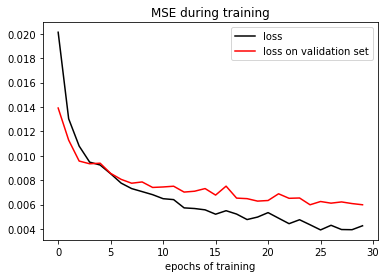

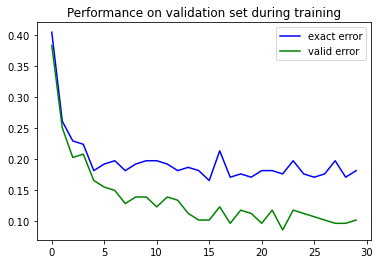

Testing on test set ...
Valid representations :  216 / 238
Exact representations :  196 / 238
MSE on test :  0.005728401502529119
RMSE on test :  0.07568620417572226
Testing on training set ...
Valid representations :  866 / 891
Exact representations :  853 / 891
MSE on test :  0.0018892614668947962
RMSE on test :  0.04346563547096483


KeyError: 'cup'

In [47]:
lstm_units = 80
for _ in np.arange(1):
    if __name__ == "__main__":
        for i in np.arange(1):
            if use_save_version:
                model = keras.models.load_model(path + "best_model"+rand_id+".hdf5")
                if test_version:
                    model_for_test = keras.models.load_model(path + "best_model_for_test"+rand_id+".hdf5")

            else:
                rand_id = str(np.random.random()) #random id used for the file names during the model save

                #build the model
                if test_version:
                    inp = Input((max_seq_len, nb_unique_words))
                    masked = Masking(mask_value=special_value)(inp)
                    lstm_out, state_h, state_c = LSTM(lstm_units, return_sequences=True,return_state = True, dropout = dropout)(masked)

                    attention_weights, attention_output = Attention(80)(lstm_out)
                    output_to_train = Dense(output_size)(attention_output)

                    model = Model(inputs = inp, outputs = output_to_train)
                    model_for_test = Model(inputs = inp, outputs = [output_to_train, state_h, state_c])
                    model.compile(loss='mean_squared_error', optimizer='adam')
                    model_for_test.compile(loss='mean_squared_error', optimizer='adam')

                    if verbose_training:
                        print("model for hidden states: ", model_for_test.summary())
                else:
                    model = Sequential()
                    model.add(Masking(mask_value=special_value, input_shape=(max_seq_len, nb_unique_words)))
                    model.add(LSTM(lstm_units, stateful=False))
                    model.add(Dense(output_size))
                    model.compile(loss='mean_squared_error', optimizer='adam')

                if verbose_training:
                    print(model.summary()) # print the architecture of the model

                if not(minimal_mode):
                    history = LossHistory() #to get the evolution of the loss during training
                    checkpoint = ModelCheckpoint("saved_LSTM/best_model"+rand_id+".hdf5",
                                                monitor='val_loss', verbose=1,
                                                mode='auto', period=1, save_best_only = True) #we save the model after each epoch of training
                    earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

                t1 = time.process_time()

                #training
                if minimal_mode:
                    model.fit(trainX_pad, trainY, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
                else:
                    model.fit(trainX_pad, trainY, epochs=nb_epoch, batch_size=batch_size, verbose=2, shuffle=False, callbacks=[history, checkpoint, earlystopping], validation_data=(validationX_pad, validationY))


                t2 = time.process_time()

                if verbose_training:
                    print("End of training !")
                    print("CPU Time to train : ", t2 -t1)
                if not(minimal_mode):
                    model_for_test.save("saved_LSTM/best_model_for_test"+rand_id+".hdf5")
                    history.plot_loss()


            if verbose_training:
                print("Testing on test set ...")
            v, ex, er = test_on_test_set(model, testX_pad[0:] , testY[0:], test_sentences[0:], verbose_training, threshold_factor)
            if minimal_mode:
                print(str(nb_objects) + "," +str(v) + "," + str(ex) + ","+ str(er) + "," + str(t2-t1))

            if not(minimal_mode):
                if verbose_training:
                    print("Testing on training set ...")
                v, ex, er = test_on_test_set(model, trainX_pad , trainY, train_sentences, True, threshold_factor)


            #qualitative analysis of the output of the LSTM
            if not(minimal_mode):
                test_sent = ["BEGIN on the middle is a green glass and that is a orange bowl END", #0
                "BEGIN and on the middle is a green glass and that is a orange bowl END",
                "BEGIN a blue bowl is on the right and on the right there is the blue bowl END",
                "BEGIN on the middle there is the orange and the orange on the middle is orange END", #3
                "BEGIN the orange is orange and on the middle there is the green cup END",
                "BEGIN on the left there is a blue glass and this is a orange END",
                "BEGIN the glass on the left is blue and the bowl on the right is green END", #6
                "BEGIN the orange on the right is green and there is a blue cup on the middle END",
                "BEGIN on the right there is a red glass and the cup on the middle is red END",
                "BEGIN a green glass is on the right and on the left is a orange END"] #9

                #plot the final outputs on a test sentence
                outputs = test_with_sentences(test_sent , model)
                ind = i
                plot_final_activation(outputs[ind],
                                    concepts_delimitations,
                                    output_id_to_concept_dict,
                                    nb_concepts,
                                    test_sent[ind])

                #plot and save to png the evolution of the LSTM outputs during the processing of a sentence
                s = test_sent[ind]
                suc_outputs = get_successive_outputs(s, model)
                plot_concept_activation(s,
                                        suc_outputs,
                                        concepts_delimitations,
                                        nb_concepts,
                                        savefig = True,
                                        sub_ttl_fig = s + " LSTM")


                #plot the evolution of cell activity
                activations = get_successive_outputs(s, model_for_test)
                plot_hidden_states(s,
                                model_for_test,
                                units_to_plot = 'all',
                                state = 'cell',
                                plt_var = True,
                                plt_sum = False)

In [44]:
#from keras.models import load_model
#model_for_test = load_model("saved_LSTM/best_model_for_test0.012230777794171699.hdf5")
#model = load_model("saved_LSTM/best_model0.012230777794171699.hdf5")
#verbose_training = True
if verbose_training:
        print("Testing on test set ...")
        v, ex, er = test_on_test_set(model, testX_pad[0:] , testY[0:], test_sentences[0:], verbose_training, threshold_factor)
        if minimal_mode:
            print(str(nb_objects) + "," +str(v) + "," + str(ex) + ","+ str(er) + "," + str(t2-t1))

        if not(minimal_mode):
            if verbose_training:
                print("Testing on training set ...")
            v, ex, er = test_on_test_set(model, trainX_pad , trainY, train_sentences, True, threshold_factor)


        #qualitative analysis of the output of the LSTM
        if not(minimal_mode):
            test_sent = ['BEGIN this is a yellow and black rubber hammer. END',
       'BEGIN a yellow bananna END',
       'BEGIN this is a small black flashlight with an attached cloth handle. END',
       'BEGIN the object is a lemon. it is uncut with a sticker still on the skin. END',
       'BEGIN this is a tub of toothpaste with a blue label. END',
       'BEGIN a green marker. END',
       'BEGIN it is a pair of blue and red pliers. END',
       'BEGIN it is a white led lightbulb. END',
       'BEGIN a small white onion. END',
       'BEGIN on the turntable is a metal hammer with a yellow and black plastic handle. END'] #9

            #plot the final outputs on a test sentence
            outputs = test_with_sentences(test_sent , model)
            ind = 0
            plot_final_activation(outputs[ind],
                                concepts_delimitations,
                                output_id_to_concept_dict,
                                nb_concepts,
                                test_sent[ind])

            #plot and save to png the evolution of the LSTM outputs during the processing of a sentence
            s = test_sent[ind]
            suc_outputs = get_successive_outputs(s, model)
            plot_concept_activation(s,
                                    suc_outputs,
                                    concepts_delimitations,
                                    nb_concepts,
                                    savefig = True,
                                    sub_ttl_fig = s + " LSTM")


            #plot the evolution of cell activity
            activations = get_successive_outputs(s, model_for_test)
            plot_hidden_states(s,
                            model_for_test,
                            units_to_plot = 'all',
                            state = 'cell',
                            plt_var = True,
                            plt_sum = False)

Testing on test set ...
Valid representations :  211 / 238
Exact representations :  198 / 238
MSE on test :  0.005932346343971387
RMSE on test :  0.0770217264411243
Testing on training set ...
Valid representations :  818 / 891
Exact representations :  809 / 891
MSE on test :  0.0027140755568599586
RMSE on test :  0.052096790274065434


KeyError: 'hammer.'

In [51]:
def output_to_vision(output, nb_concepts, factor,
                     concepts_delimitations, output_id_to_concept_dict):
    objs = []
    nb_objects = 2
    for j in range(nb_objects):
        cat = [None] * 3
        offset = j*nb_concepts
        for i in range(len(concepts_delimitations)):
            cat_activations = output[offset+concepts_delimitations[i][0]:offset+concepts_delimitations[i][1]]
            proba = softmax(cat_activations)
            concept = np.argmax(proba)
            #the threshold to be accepted depend on the number of concept to choose from : must be a factor higher than the uniform proba
            threshold = factor / (concepts_delimitations[i][1] - concepts_delimitations[i][0])
            if proba[concept] < threshold:
                cat[i] = None
            else:
                cat[i] = output_id_to_concept_dict[concepts_delimitations[i][0] + concept]

        objs.append(RecognizedObject(cat[0], cat[1], cat[2])) #object, position, color

    return objs